In [139]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime, pickle

style.use('ggplot')

df = quandl.get("WIKI/GOOGL")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
forecast_col = 'Adj. Close'
df.fillna(value=-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
print(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

y = np.array(df['label'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)
    


[[-1.39187095  4.25846492  0.23254018  4.46712802]
 [-1.37635178  4.15018674  4.81828847  1.8207495 ]
 [-1.37423066  1.3780063  -0.79917922  1.26561472]
 ...
 [ 2.39583323  1.40180729 -1.55184968 -0.65539548]
 [ 2.50268682  1.78591425  0.23733959 -0.55124957]
 [ 2.31974758  3.23683162 -3.54051775 -0.59144015]]


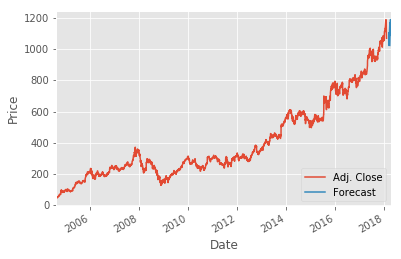

                     Adj. Close  HL_PCT  PCT_change  Adj. Volume  label  \
Date                                                                      
2018-04-12 11:30:00         NaN     NaN         NaN          NaN    NaN   
2018-04-13 11:30:00         NaN     NaN         NaN          NaN    NaN   
2018-04-14 11:30:00         NaN     NaN         NaN          NaN    NaN   
2018-04-15 11:30:00         NaN     NaN         NaN          NaN    NaN   
2018-04-16 11:30:00         NaN     NaN         NaN          NaN    NaN   

                        Forecast  
Date                              
2018-04-12 11:30:00  1115.684012  
2018-04-13 11:30:00  1072.589710  
2018-04-14 11:30:00  1045.331767  
2018-04-15 11:30:00  1072.731762  
2018-04-16 11:30:00  1022.967212  


In [141]:
confidence = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
print(df.tail(5))